<a href="https://colab.research.google.com/github/lakshyasinghal25/Fairness-Aware-Movie-Recommendation/blob/master/movieRecommenderSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from collections import defaultdict

In [81]:
tf.__version__

'2.18.0'

In [4]:
ratings_file = "u.data"
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(ratings_file, sep='\t', names=ratings_cols)
ratings = ratings.drop('unix_timestamp', axis=1)
# ratings

In [5]:
user_attributes_file = "u.user"
user_attributes_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(user_attributes_file, sep='|', names=user_attributes_cols)
# users

In [6]:
ratings['count'] = ratings.groupby('user_id')['movie_id'].transform('count')
ratings = ratings[ratings['count'] >= 300]
users['gender'] = users['gender'].map(lambda x: 1 if x == 'F' else 0)
users = users.drop(['age', 'occupation', 'zip_code'], axis=1)

# len(ratings['user_id'].unique())

In [7]:
df = pd.merge(ratings, users, on='user_id', how='left')
df.head()
# len(df['user_id'].unique())

,user_id,movie_id,rating,count,gender
0,303,785,3,484,0
1,194,274,2,305,0
2,234,1184,2,480,0
3,308,1,4,397,0
4,181,1081,1,435,0


In [8]:
user_ids = df['user_id'].unique().tolist()
movie_ids = df['movie_id'].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df['users'] = df['user_id'].map(user2user_encoded)
df['movies'] = df['movie_id'].map(movie2movie_encoded)

num_users = len(user_ids)
num_movies = len(movie_ids)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

df['rating'] = df['rating'].values.astype(np.float32)

print(f'Number of users: {num_users}')
print(f'Number of movies: {num_movies}')
print(f'Min rating: {min_rating}')
print(f'Max rating: {max_rating}')
print(df.head())

Number of users: 54
Number of movies: 1597
Min rating: 1
Max rating: 5
   user_id  movie_id  rating  count  gender  users  movies
0      303       785     3.0    484       0      0       0
1      194       274     2.0    305       0      1       1
2      234      1184     2.0    480       0      2       2
3      308         1     4.0    397       0      3       3
4      181      1081     1.0    435       0      4       4


In [9]:
df = df.sample(frac=1, random_state=42)
x = df[['users', 'movies']].values

y_rating = df['rating'].map(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y_gender = df['gender'].values

train_indices = int(0.9 * df.shape[0])

x_train = x[:train_indices]
x_val = x[train_indices:]

y_train = [
    y_rating[:train_indices],
    y_gender[:train_indices],
    y_gender[:train_indices],
    y_gender[:train_indices],
    y_gender[:train_indices],
    np.zeros(train_indices),
    np.zeros(train_indices)
]

y_val = [
    y_rating[train_indices:],
    y_gender[train_indices:],
    y_gender[train_indices:],
    y_gender[train_indices:],
    y_gender[train_indices:],
    np.zeros(df.shape[0] - train_indices),
    np.zeros(df.shape[0] - train_indices)
]

print('x_train : ',x_train.shape)
y_train[0][0:10]

x_train :  (18944, 2)


array([1.  , 0.5 , 0.5 , 1.  , 0.5 , 0.75, 0.25, 0.5 , 0.75, 1.  ])

**Q. How are bias-free user embeddings learned?**

Usually, the supervision of the main recommendation task may also encode the bias information about sensitive user attribute into the bias-free user embedding. Thus, in order to eliminate the bias information, we propose to apply adversarial learning to the bias-free user embedding.

A straightforward way is to apply an *attribute discriminator* to the user embeddings learned by the user model to infer the sensitive user attribute, and penalize the model according to the *negative gradients* from the adversarial loss that indicates the informativeness of user embeddings for sensitive user attribute prediction.

---
**Q. What is the need for bias-aware user embeddings?**

The user embeddings are also used to evaluate the relevance between the user and candidate movie for movie recommendation model training. Unfortunately, users’ sensitive attributes may be informative for the main movie recommendation task, and the bias information related to the sensitive user attribute may be encoded into the user embeddings, making it difficult to be removed by adversarial learning.

As an alternative, we propose to decompose the user interest model into two components:

- **Bias-aware component**: Aims to learn bias-aware user embeddings that capture the bias information on sensitive user attributes.
- **Bias-free component**: Encodes only the attribute-independent information of user interest into bias-free user embeddings.

To push the bias-aware user embedding to be more attribute-discriminative, we propose to apply a *sensitive attribute prediction task* to the bias-aware user embedding.


---
**Q. Why is orthogonal regulariation needed then?**

Unfortunately, the bias-free user embedding may still contain some information related to the sensitive user attribute. This is because the discriminator usually cannot perfectly infer the sensitive user attribute, and there are shifts between the decision boundary of the discriminator and the real distribution of the sensitive user attribute. Since the bias-free user embedding generated by the user model only needs to cheat the discriminator, it does not necessarily fully remove the information of sensitive user attributes.

To solve this problem, we propose an orthogonality regularization
method to further purify the bias-free user embedding. Concretely, it regularizes the bias-aware user embedding and bias-free user embedding by encouraging them to be orthogonal to each other.



In [10]:
EMBEDDING_SIZE = 50

class RecSys(keras.Model):
    def __init__(self, num_users, num_movies, **kwargs):
        super().__init__(**kwargs)

        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = EMBEDDING_SIZE

        # 4 user embeddings
        self.user_embedding_biased_mlp = layers.Embedding(
            num_users,
            EMBEDDING_SIZE,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.user_embedding_biased_gmf = layers.Embedding(
            num_users,
            EMBEDDING_SIZE,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.user_embedding_fair_mlp = layers.Embedding(
            num_users,
            EMBEDDING_SIZE,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.user_embedding_fair_gmf = layers.Embedding(
            num_users,
            EMBEDDING_SIZE,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )

        # 2 movie embeddings
        self.movie_embedding_mlp = layers.Embedding(
            num_movies,
            EMBEDDING_SIZE,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )
        self.movie_embedding_gmf = layers.Embedding(
            num_movies,
            EMBEDDING_SIZE,
            embeddings_initializer = 'he_normal',
            embeddings_regularizer = keras.regularizers.l2(1e-6)
        )

        # mlp for combining user embeddings for mlp and movie embeddings for mlp
        self.mlp = keras.models.Sequential([
            layers.Dense(4*EMBEDDING_SIZE, activation='relu'),
            layers.Dense(2*EMBEDDING_SIZE, activation='relu'),
            layers.Dense(EMBEDDING_SIZE),
        ])

        # NN(no hidden layers) to combine mlp and gmf outputs
        self.neuCF = layers.Dense(1)

        # 2 NNs(no hdden layers) for attribute predictors
        self.att_predictor_mlp = layers.Dense(1)
        self.att_predictor_gmf = layers.Dense(1)

        # 2 NNs(no hdden layers) for attribute discriminator
        self.att_discriminator_mlp = layers.Dense(1)
        self.att_discriminator_gmf = layers.Dense(1)

    # Function called for training NN
    def call(self, inputs):
        # getting the user embeddings
        u_b_mlp = self.user_embedding_biased_mlp(inputs[:, 0])
        u_b_gmf = self.user_embedding_biased_gmf(inputs[:, 0])
        u_f_mlp = self.user_embedding_fair_mlp(inputs[:, 0])
        u_f_gmf = self.user_embedding_fair_gmf(inputs[:, 0])

        # getting movie embeddings
        m_mlp = self.movie_embedding_mlp(inputs[:, 1])
        m_gmf = self.movie_embedding_gmf(inputs[:, 1])

        # combining fair and biased user embeddings
        u_mlp = tf.add(u_f_mlp, u_b_mlp)
        u_gmf = tf.add(u_f_gmf, u_b_gmf)

        # final gmf and mlp layers
        gmf_layer = tf.multiply(u_gmf, m_gmf)
        mlp_layer = self.mlp(tf.concat([u_mlp, m_mlp], axis=1))

        # final predicted rating
        predicted_rating = self.neuCF(tf.concat([gmf_layer, mlp_layer], axis=1))

        # attribute predictor
        g_b_mlp = self.att_predictor_mlp(u_b_mlp)
        g_b_gmf = self.att_predictor_gmf(u_b_gmf)

        # attribute discriminator
        g_f_mlp = self.att_discriminator_mlp(u_f_mlp)
        g_f_gmf = self.att_discriminator_gmf(u_f_gmf)

        # computing orthogonal loss which must be minimised
        ortho_loss_mlp = layers.Dot(axes=1, normalize=True)([u_b_mlp, u_f_mlp])
        ortho_loss_gmf = layers.Dot(axes=1, normalize=True)([u_b_gmf, u_f_gmf])

        # the sigmoid activation forces the rating to between 0 and 1
        return [predicted_rating, tf.nn.sigmoid(g_b_mlp), tf.nn.sigmoid(g_b_gmf), tf.nn.sigmoid(g_f_mlp), tf.nn.sigmoid(g_f_gmf), ortho_loss_mlp, ortho_loss_gmf]

def neg_binary_crossentropy(y_true, y_pred):
    return -1.0 * keras.losses.binary_crossentropy(y_true, y_pred)

def root_mean_squared_error(y_true, y_pred):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

model = RecSys(num_users, num_movies)

model.compile(
    loss=[root_mean_squared_error, tf.keras.losses.BinaryCrossentropy(), tf.keras.losses.BinaryCrossentropy(), neg_binary_crossentropy, neg_binary_crossentropy, tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredError()],
    loss_weights=[1,0.5,0.5,0.5,0.5,0.5,0],
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

# model.compile(
#     loss={
#         "ratings_prediction_loss" : root_mean_squared_error,
#         "l1" : tf.keras.losses.BinaryCrossentropy(),
#         "l2" : tf.keras.losses.BinaryCrossentropy(),
#         "l3" : neg_binary_crossentropy,
#         "l4" : neg_binary_crossentropy,
#         "l5" : tf.keras.losses.MeanSquaredError(),
#         "l6" : tf.keras.losses.MeanSquaredError()
#     },
#     loss_weights=[1,0.5,0.5,0.1,0.1,0.5,0.5],
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
# )

In [11]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=7,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/7
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - binary_crossentropy_loss: 0.4649 - loss: -0.6525 - mean_squared_error_loss: 0.0108 - neg_binary_crossentropy_loss: -1.5031 - root_mean_squared_error_loss: 0.2929 - val_binary_crossentropy_loss: 0.0500 - val_loss: -8.2602 - val_mean_squared_error_loss: 9.1542e-04 - val_neg_binary_crossentropy_loss: -9.2412 - val_root_mean_squared_error_loss: 0.2365
Epoch 2/7
296/296 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_crossentropy_loss: 0.0326 - loss: -13.6780 - mean_squared_error_loss: 5.7199e-04 - neg_binary_crossentropy_loss: -14.7699 - root_mean_squared_error_loss: 0.2258 - val_binary_crossentropy_loss: 0.0095 - val_loss: -34.4449 - val_mean_squared_error_loss: 6.3197e-05 - val_neg_binary_crossentropy_loss: -35.7431 - val_root_mean_squared_error_loss: 0.2374
Epoch 3/7
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_crossentropy_loss: 0.0076 - loss: -43.7680 - mean_squared_error_loss: 4.7199e-05 - neg_binary_crossentropy_loss: -45.1012 - ro

In [12]:
# for x, y in history.history.items():
#     print(x, [round(x, 6) for x in y])

binary_crossentropy_loss [0.281698, 0.022256, 0.006048, 0.002706, 0.001497, 0.00093, 0.000624]
loss [-2.462884, -19.939154, -53.845757, -102.252708, -163.850357, -237.580795, -322.456146]
mean_squared_error_loss [0.006008, 0.000329, 3.7e-05, 1.6e-05, 1.3e-05, 8e-06, 6e-06]
neg_binary_crossentropy_loss [-3.279149, -21.104788, -55.195305, -103.67926, -165.329727, -239.105621, -324.031403]
root_mean_squared_error_loss [0.261174, 0.229223, 0.219315, 0.213036, 0.210313, 0.206048, 0.203289]
val_binary_crossentropy_loss [0.050031, 0.009542, 0.003713, 0.001911, 0.001139, 0.000742, 0.000513]
val_loss [-8.260236, -34.44487, -75.922211, -131.164932, -199.096802, -278.604919, -368.867615]
val_mean_squared_error_loss [0.000915, 6.3e-05, 2.4e-05, 1.4e-05, 1.1e-05, 7e-06, 5e-06]
val_neg_binary_crossentropy_loss [-9.241161, -35.743103, -77.33725, -132.646469, -200.628845, -280.195099, -370.511322]
val_root_mean_squared_error_loss [0.236461, 0.23739, 0.239611, 0.243359, 0.243961, 0.250485, 0.248002]


In [13]:
model.evaluate(x_val, y_val)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_crossentropy_loss: 5.1185e-04 - loss: -368.9507 - mean_squared_error_loss: 4.8449e-06 - neg_binary_crossentropy_loss: -370.5387 - root_mean_squared_error_loss: 0.2413


[-368.86865234375,
 0.24695292115211487,
 0.0005130692734383047,
 0.0005130692734383047,
 -370.50787353515625,
 -370.50787353515625,
 4.952264134772122e-06,
 4.952264134772122e-06]

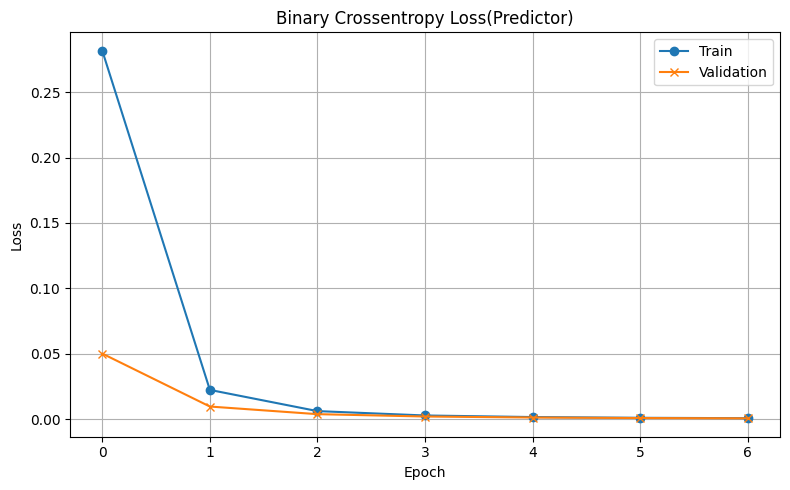

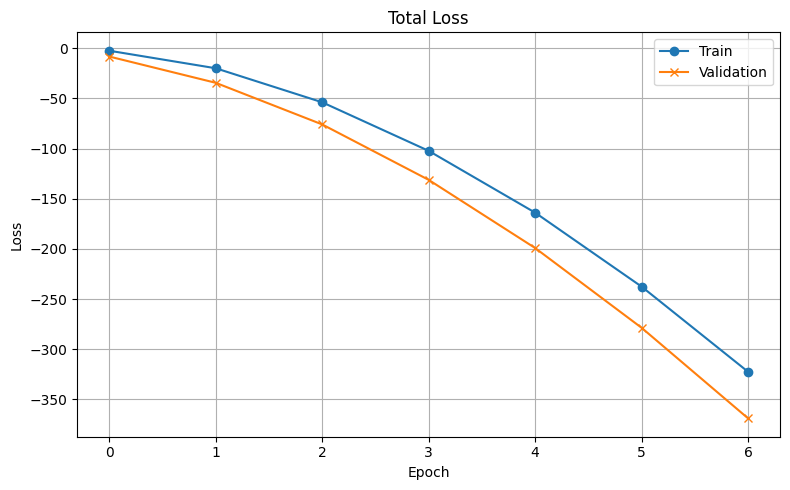

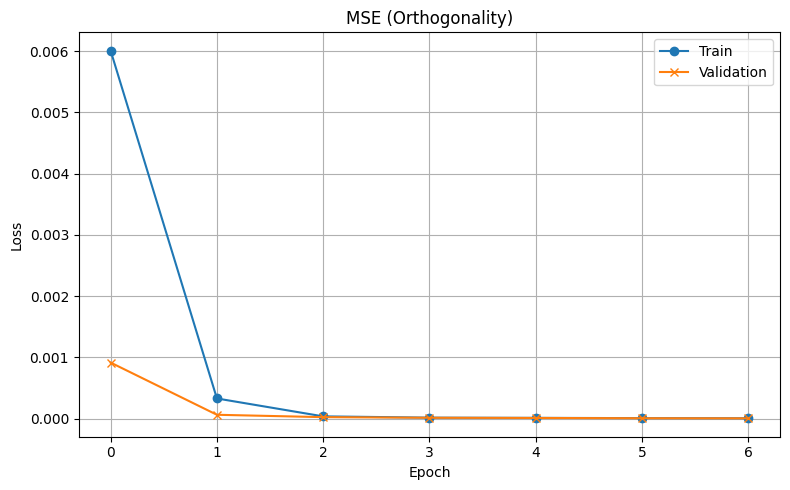

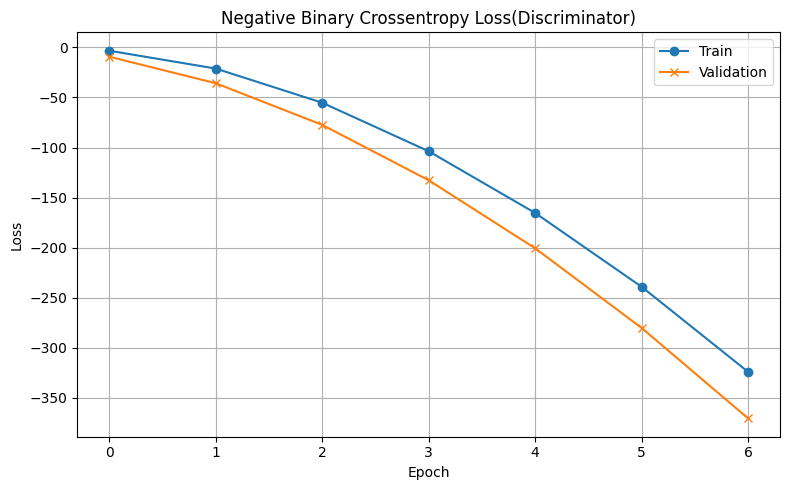

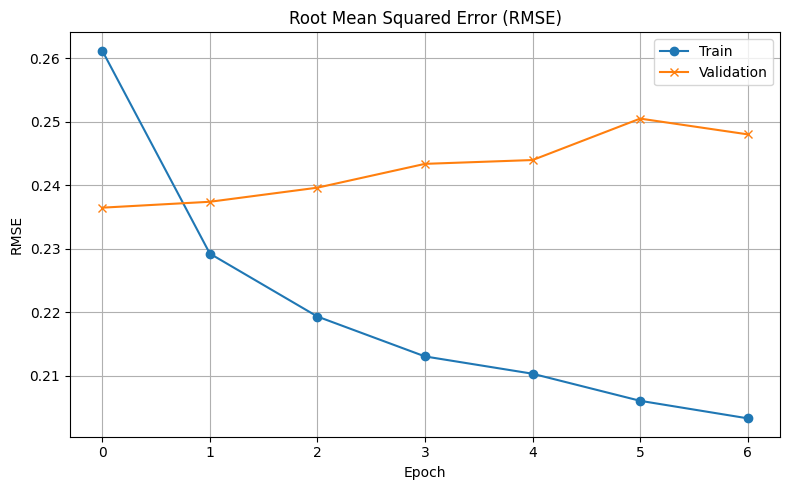

In [14]:
def plot_metrics(history, key, title, ylabel):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history[key], marker='o', label='Train')
    plt.plot(history.history["val_" + key], marker='x', label='Validation')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the plot function for each metric
plot_metrics(history, "binary_crossentropy_loss", "Binary Crossentropy Loss(Predictor)", "Loss")
plot_metrics(history, "loss", "Total Loss", "Loss")
plot_metrics(history, "mean_squared_error_loss", "MSE (Orthogonality)", "Loss")
plot_metrics(history, "neg_binary_crossentropy_loss", "Negative Binary Crossentropy Loss(Discriminator)", "Loss")
plot_metrics(history, "root_mean_squared_error_loss", "Root Mean Squared Error (RMSE)", "RMSE")

In [15]:
# UNIFIED USER EMBEDDINGS

ub_mlp_w = np.array(model.user_embedding_biased_mlp.get_weights())
ub_gmf_w = np.array(model.user_embedding_biased_gmf.get_weights())
# print(np.shape(model.user_embedding_biased_mlp.get_weights()))
uf_mlp_w = np.array(model.user_embedding_fair_mlp.get_weights())
uf_gmf_w = np.array(model.user_embedding_fair_gmf.get_weights())

unified_user_embedding = layers.Embedding(
            num_users,
            EMBEDDING_SIZE,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

output = unified_user_embedding(x_train[:,0])
# print(np.shape(unified_user_embedding.get_weights()))
w_mlp = np.add(ub_mlp_w, uf_mlp_w)
w_gmf = np.add(ub_gmf_w, uf_gmf_w)
w = np.add(w_mlp,w_gmf)
unified_user_embedding.set_weights(w)

# print(w.shape)

In [16]:
# TESTING

movies_embedding = model.movie_embedding_mlp
uv = model.user_embedding_biased_mlp(x_train[:,0])
mv = movies_embedding(x_train[:,1])
scores = tf.reshape(tf.reduce_sum( tf.multiply( uv, mv ), 1, keepdims=True ),[-1])

mse = tf.keras.losses.MeanSquaredError()
mse(y_train[0], scores).numpy()

np.float32(0.42465782)

In [17]:
movie_df = pd.read_csv('u.item', sep='|', header=None, encoding='latin-1')
movie_df = movie_df[[0, 1]]
movie_df.columns = ['movie_id', 'title']
movie_df.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [18]:
# TOP 10 FAIRNESS AWARE MOVIE RECOMMENDATIONS FOR A RANDOM USER USING BIAS-FREE EMBEDDINGS

user_id = df.user_id.sample(1).iloc[0] # Keep this in another cell else random user will change each time the cell runs

movies_watched_by_user = df[df.user_id == user_id]
movies_not_watched = movie_df[~movie_df['movie_id'].isin(movies_watched_by_user.movie_id.values)]['movie_id']
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

# print('len : ',len(user_movie_array))
uv = unified_user_embedding(user_movie_array[:,0])
mv = movies_embedding(user_movie_array[:,1])
ratings = tf.reshape(tf.reduce_sum( tf.multiply( uv, mv ), 1, keepdims=True ),[-1]).numpy()
# print(ratings)

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movie_id.values
)
movie_df_rows = movie_df[movie_df["movie_id"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movie_id"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title)

Showing recommendations for user: 234
Movies with high ratings from user
--------------------------------
Manon of the Spring (Manon des sources) (1986)
Sting, The (1973)
Lawrence of Arabia (1962)
Third Man, The (1949)
Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (1970)
--------------------------------
Top 10 movie recommendations
--------------------------------
Pillow Book, The (1995)
Kull the Conqueror (1997)
First Wives Club, The (1996)
Wyatt Earp (1994)
Terminal Velocity (1994)
Jackal, The (1997)
Daylight (1996)
Mixed Nuts (1994)
Before and After (1996)
I'll Do Anything (1994)


In [19]:
# Evaluation

uv = unified_user_embedding(x_val[:,0])
mv = movies_embedding(x_val[:,1])
ratings = tf.reshape(tf.reduce_sum( tf.multiply( uv, mv ), 1, keepdims=True ),[-1]).numpy()
ratings = tf.nn.sigmoid(ratings)
# print(len(y_val[0]), len(ratings))
# print(y_val[0])
# print(ratings)

rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_val[0],ratings)
print('RMSE : ',rmse.result().numpy())
r2 = r2_score(y_val[0], np.array(ratings)) # Tells whether Model explains the variance in the dataset (1 -> perfect, 0 -> same as predicting mean for all, negative -> worse)
print('Coefficient of Determination : ',r2)

RMSE :  0.38746342
Coefficient of Determination :  -0.8355266685589122


In [61]:
# FAIRNESS EVALUATION

discriminator = keras.Sequential([
    layers.Input(shape=(EMBEDDING_SIZE,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

gender_labels = []
for key in user_encoded2user:
    gender_labels.append(df.loc[df["users"] == key, "gender"].values[0])
gender_labels = np.array(gender_labels).astype(int)

# len(gender_labels)
biased_embeddings = np.array(ub_mlp_w[0])
fair_embeddings = np.array(uf_mlp_w[0])
# print(fair_embeddings.shape, len(gender_labels))
history = discriminator.fit(biased_embeddings, gender_labels, epochs=10, batch_size=32)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5864 - loss: 0.6632 
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8492 - loss: 0.6015
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9402 - loss: 0.5534
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9545 - loss: 0.5071
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.4648
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.4226
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.3841
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.3479
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.3100
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.2812


In [66]:
gender_predictions = discriminator.predict(fair_embeddings)
score = 0
for x in gender_predictions:
    score += abs(x-0.5)

score /= len(gender_predictions)
print(score)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.15081911]


In [78]:
yr = model.predict(x_val)[0]
yr.shape

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(2105, 1)

In [96]:
e_g_y_j_all = defaultdict(list)
e_neg_g_y_j_all = defaultdict(list)
e_g_r_j_all = defaultdict(list)
e_neg_g_r_j_all = defaultdict(list)

# print("---",np.count_nonzero(y_val[1]==1))
# print(x_val.shape)
for i in range(len(x_val)):
    if(y_val[1][i] == 1): #female
        e_g_y_j_all[x_val[i][1]].append(yr[i][0])
        e_g_r_j_all[x_val[i][1]].append(y_val[0][i])
    if(y_val[1][i] == 0): #male
        e_neg_g_y_j_all[x_val[i][1]].append(yr[i][0])
        e_neg_g_r_j_all[x_val[i][1]].append(y_val[0][i])

In [105]:
e_g_y_j = {}
e_neg_g_y_j = {}
e_g_r_j = {}
e_neg_g_r_j = {}
for k in e_g_y_j_all:
  e_g_y_j[k] = np.nanmean(e_g_y_j_all[k])
for k in e_g_r_j_all:
  e_g_r_j[k] = np.nanmean(e_g_r_j_all[k])
for k in e_neg_g_y_j_all:
  e_neg_g_y_j[k] = np.nanmean(e_neg_g_y_j_all[k])
for k in e_neg_g_r_j_all:
  e_neg_g_r_j[k] = np.nanmean(e_neg_g_r_j_all[k])
# print(e_g_y_j)

{np.int64(621): np.float32(0.9250779), np.int64(1): np.float32(0.6014305), np.int64(775): np.float32(0.36351994), np.int64(793): np.float32(0.69094694), np.int64(314): np.float32(0.5172987), np.int64(174): np.float32(0.21363716), np.int64(6): np.float32(-0.016582482), np.int64(197): np.float32(0.84533334), np.int64(1406): np.float32(0.25681913), np.int64(1016): np.float32(0.4761835), np.int64(557): np.float32(0.8788709), np.int64(219): np.float32(0.09283528), np.int64(653): np.float32(0.6724158), np.int64(809): np.float32(1.0584705), np.int64(741): np.float32(0.62075484), np.int64(748): np.float32(0.82036024), np.int64(850): np.float32(0.580189), np.int64(319): np.float32(0.43136346), np.int64(539): np.float32(0.4714172), np.int64(1044): np.float32(0.74475986), np.int64(1564): np.float32(0.48881888), np.int64(532): np.float32(0.93561494), np.int64(481): np.float32(0.66900074), np.int64(698): np.float32(0.5829864), np.int64(253): np.float32(0.724688), np.int64(1418): np.float32(0.727089

/tmp/ipython-input-105-3645565847.py:10: RuntimeWarning: Mean of empty slice
  e_neg_g_y_j[k] = np.nanmean(e_neg_g_y_j_all[k])


In [104]:
movies = set(x_val[:,1])
l = len(movies)
# print(l)

def safe_val(d, key):
    val = d.get(key, 0)
    return 0 if val is None or np.isnan(val) else val

val_score, abs_score, over_est, under_est = 0.0, 0.0, 0.0, 0.0

for movie in movies:
    eg_y = safe_val(e_g_y_j, movie)
    eg_r = safe_val(e_g_r_j, movie)
    eng_y = safe_val(e_neg_g_y_j, movie)
    eng_r = safe_val(e_neg_g_r_j, movie)

    val_score += np.abs((eg_y - eg_r) - (eng_y - eng_r))
    abs_score += np.abs(np.abs(eg_y - eg_r) - np.abs(eng_y - eng_r))
    over_est += np.abs(np.maximum(0, eg_y - eg_r) - np.maximum(0, eng_y - eng_r))
    under_est += np.abs(np.maximum(0, eg_r - eg_y) - np.maximum(0, eng_r - eng_y))

val_score /= l
abs_score /= l
over_est /= l
under_est /= l

print(val_score, abs_score, over_est, under_est)

906
0.2043735283792401 0.17302988302974903 0.10333245231617356 0.10104107606306655
